<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/LP_interior_point.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interior Point Method for Linear Programming

This notebook explores the use of [interior point methods](https://en.wikipedia.org/wiki/Interior-point_method) for linear programming, and it is a simplified version of the respective [numerical tour](https://www.numerical-tours.com/python/), created by Dr. Gabriel Peyre. The definite reference for interior point methods is the book ["Convex Optimization"](https://web.stanford.edu/~boyd/cvxbook/) of Boyd and Vandenberghe.

$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\DeclareMathOperator{\eqdef}{\overset{\tiny def}{=}}$

In [ ]:
import math as m
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from dataclasses import dataclass
np.random.seed(124) # to ensure reproducibility
cp.installed_solvers();

## Problem formulation and solution with Solver

The goal is to solve problem of the form:
$$
 \umin{x\in \RR^n, A x \leq b} c^Tx
$$
for $A \in \RR^{m \times n}$. Note, this means we have m constraints and n variables.

This can be generalized for instance by replacing $c^Tx$ with a convex function, or add convex inequality constraints, since the interior point method also works for convex programs. Next, we generate a large random LP instance.

In [ ]:
@dataclass
class LPInstance:
  A: np.ndarray
  b: np.ndarray
  c: np.ndarray

  @property
  def m(self) -> int:
    return self.b.shape[0]

  @property
  def n(self) -> int:
    return self.c.shape[0]

# Create lp1, a random LP instance
m, n = 40, 30                       # select dimensions
np.random.seed(1)                   # pick a random seed to get repeatable experiments
s0 = np.random.exponential(10, m)   # random slack vector
x0 = tuple(np.random.randn(n))      # this is an initial feasible solution (named as constant as we dont want to modify this)
A = np.random.randn(m, n)           # pick A_ij zero-mean gausian with std 1
b = A @ np.array(x0) + s0                # pick b_i to provide slack to the initial feasible solution
c = -A.T @ s0                       # pick c_j

lp1 = LPInstance(A, b, c) # generate the instance

print(f"Is x_init = {np.array(x0)} feasible? {np.all(lp1.A @ np.array(x0)-lp1.b <= np.zeros(lp1.m))}")
a = 0.0001
x1 = a* np.ones(lp1.n)+np.array(x0)
print(f"Is x1 = x0 + {a}*(1, 1, ..., 1) feasible?",np.all(lp1.A @ x1-lp1.b <= np.zeros(lp1.m)))
# is A full rank?
print(f"Rank(A) = {np.linalg.matrix_rank(lp1.A)} and n = {lp1.n}") # if equal to n, the Hessian of the Barrier problem below is non-singular if Ax<b

Is x_init = [ 0.90085595 -0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547
 -0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613 -0.0126646
 -1.11731035  0.2344157   1.65980218  0.74204416 -0.19183555 -0.88762896
 -0.74715829  1.6924546   0.05080775 -0.63699565  0.19091548  2.10025514
  0.12015895  0.61720311  0.30017032 -0.35224985 -1.1425182  -0.34934272] feasible? True
Is x1 = x0 + 0.0001*(1, 1, ..., 1) feasible? True
Rank(A) = 30 and n = 30


In [ ]:
# Define and solve the CVXPY problem.
x = cp.Variable(lp1.n)
prob = cp.Problem(cp.Minimize(lp1.c.T @ x), [lp1.A @ x <= lp1.b])

# Use an interior point method
#prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
prob.solve(solver='GLPK_MI')

# Print result.
print("The optimal value is", prob.value)
print("An optimal solution x is")
print(x.value)
#prob.solver_stats.solve_time

The optimal value is -5866.150143864937
An optimal solution x is
[  4.31298702   6.45998605 -12.03279122  13.81568319 -12.23064071
  -9.33370572  -8.73202836  -4.2804706  -10.78676183 -13.49049342
   6.53843076 -19.32028261  15.30566176  -3.55393413 -10.52748299
   2.10852214  -1.04208368 -17.69316945   0.70828113  11.31744002
  10.27126358   2.0536932   -9.16410739  -0.37122323  -1.51819674
   3.49270747 -16.56845204  -1.45151173   4.69657003  -6.63953364]


## Newton method to compute the central path

The main idea of interior point methods is to approximate the linear program with a convex program
$$
(\mathcal{B}) \qquad \umin{x\in \RR^m, } c^Tx - \frac{1}{t} \text{Log}( b-A x  )
$$
using a logarithmic [barrier function](https://en.wikipedia.org/wiki/Barrier_function)
$$
	\text{Log}(u) \eqdef \sum_i \log(u_i)
$$
so that -Log is a strictly concave function which acts as a barrier for positivity. The function $\log(s)$ should be $-\infty$ for $s < 0$. Extending the domain this way is important for the following calculations.

In [ ]:
def loginf(v: np.ndarray):
    if any(v < 0):
      return -np.inf
    return np.sum(np.log(v))

The gradient and hessian for the central path problem $f_t=c^Tx - \frac{1}{t} \text{Log}( b-A x  )$ are given by:
$$
	\nabla f_t(x) = c + \frac{1}{t} A^\top \frac{1}{b-Ax}
	\qandq
	\nabla^2 f_t(x) =  \frac{1}{t} A^\top \text{diag}\pa{\frac{1}{(b-Ax)^2}} A.
$$

In [ ]:
@dataclass
class LPGradients:
  lpi: LPInstance   # pass any lp instance

  def f(self, x: np.ndarray) -> np.ndarray:
    return self.lpi.c.T @ x

  def ft(self, x: np.ndarray, t: float) -> np.ndarray:
    return self.lpi.c.T @ x - (1 / t) * loginf(self.lpi.b - self.lpi.A @ x)

  def nablat(self, x: np.ndarray, t: float) -> np.ndarray:
    return self.lpi.c + (1 / t) * self.lpi.A.T @ (1 / (self.lpi.b - self.lpi.A @ x))

  def hessiant(self, x: np.ndarray, t:float) -> np.ndarray:
    return  (1 / t) * self.lpi.A.T @ np.diag(1 / ((self.lpi.b - self.lpi.A @ x)**2)) @ self.lpi.A

lpg1 = LPGradients(lpi = lp1)   # create an object with the gradients for our lp1 instance


In [ ]:
# checking the correctness of gradient and hessian using finite differences
# we know that 0 is a feasible point for the LP because b is chosen to be positive, hence A*0<b
t = 100                           # choose a t>0
tau = 1e-8                        # choose a small tau
x = np.array(x0)                  # above we have defined x_0 as a feasible solution
u = .01 * np.random.randn(lp1.n)  # random vector
w = np.zeros(lp1.n)               # initialize w
dim = 1                           # select a dimention 0 <= dim <= lp1.n
w[dim] = 1                        # set w_dim = 1 (to create a unit vector along this dimension)

m2 = (lpg1.ft(x + tau*w, t) - lpg1.ft(x, t)) / tau # finite difference along dim
m1 =  lpg1.nablat(x, t)
print(f'Should be close to 0: {str(m2)} - ({str(m1[dim])}) = {str(m2-m1[dim])}')

m2 = (lpg1.ft(x + tau * u, t) - lpg1.ft(x, t)) / tau # finite difference along a random direction u
m1 =  u.T @ lpg1.nablat(x, t)
print('Should be close to 0: ' + str(abs(m1 - m2) / abs(m1)))

m2 = (lpg1.nablat(x + tau * u, t) - lpg1.nablat(x, t)) / tau # finite difference of gradients along a random direction u
m1 = lpg1.hessiant(x, t) @ u
print('Should be close to 0: ' + str(np.linalg.norm(m1 - m2) / np.linalg.norm(m1)))

Should be close to 0: 62.002007439332374 - (62.00194463120799) = 6.280812438319572e-05
Should be close to 0: 3.9070112177187654e-06
Should be close to 0: 4.617707810972257e-06


In [ ]:
# checking convexity of the barrier problem
x1 = np.array(x0)                        # first point is feasible (satisfies Ax<=b)
x2 = np.array(x0) + a*np.ones(lp1.n)     # second point found feasible above
t = 0.10                                 # pick t>0 for the barrier problem
l = 0.1                                  # a nunber in (0,1)
cvx_cond = l*lpg1.ft(x1,t) + (1-l)*lpg1.ft(x2,t) - lpg1.ft(l*x1+(1-l)*x2,t)
print("The barrier function is not convex if this number is negative: ", cvx_cond)

The barrier function is not convex if this number is negative:  0.03275860104156436


## Backtracking functions for computing step sizes

To determine the step size $s_k$ at iteration $k$, we will use [Armijo's rule](https://en.wikipedia.org/wiki/Backtracking_line_search) (see also Newton notebook for more detailed explanations). Select constants  $\alpha \in (0,1/2)$ and $\beta \in (0,1)$ and then execute the following algorithm:


Armijo's rule
---
\begin{align*}
& s_k = 1 \\
& \text{While} ~~ \phi_k(s_k) > \psi_k(s_k) \text{:} \\
& \quad s_k = \beta s_k
\end{align*}
where
\begin{align*}
& \phi_k(s_k) \eqdef f(x_k + s_k d_k ) \\
& \psi_k(s_k) \eqdef f(x_k) + \alpha s_k {d_k}^T{\nabla f(x_k)}.
\end{align*}

In [ ]:
def phik(
    x:np.ndarray,     # passes variable x
    t: float,         # choice of parameter t
    sk: float,        # step size
    dk: np.ndarray,   # descent direction
    lpg: LPGradients  # object with gradients for LP
) -> float:
    return lpg.ft(x + sk * dk, t)

def psik(
    x:np.ndarray,     # passes variable x
    t: float,         # choice of parameter t
    sk: float,        # step size
    dk: np.ndarray,   # descent direction
    alpha: float,     # alpha parameter of the Armijo's rule
    lpg: LPGradients  # object with gradients for LP
) -> float:
    return lpg.ft(x, t) + alpha * sk * dk.T @ lpg.nablat(x, t)

## Newton's algorithm

Newton's method finds a descent direction by solving the above linear system of equations, or equivalently, by:
$$
d_k = - \left(\nabla^2f(x_k)\right)^{-1}\nabla f(x_k)
$$

We also define the *Newton's decrement* as $\Delta_k = \sqrt{\nabla f(x_k)^T d_k}$. A condition for stopping the algorithm is $\Delta_k^2< 2\epsilon$ (see theory).

In [ ]:
# Implementation of the Newton algorithm
# prerequisites: phik, psik

def newton(
    x: np.ndarray,          # initial solution (vector in R^n)
    t: float,               # choice of parameter t
    epsilon: float,         # accuracy parameter (when f(x)-f(x^*)< epsilon the algorithm stops)
    alpha: float,           # backtracking parameter (in (0,0.5)) typically use 0.45
    beta: float,            # step size contracting parameter (in (0,1)) typically use 0.7
    pbm: LPGradients,       # passes the gradient object for a problem we need to solve (change the class if you want to switch to a different problem)
    maxit: int = 50,        # sets a maximum iteration count for Newton steps (20 is typically enough to get to epsilon 10^-20)
    maxitb: int = 1000      # sets a maximum iteration count for backtracking
):

# OUTPUTS
#
# x: the solution in the last iteration where the algorithm stopped
# backtrack:  list with one element per iteration performed, element equals the number of backtracking steps
# ftlist:     list with one element per iteration performed, element equals the value of ft(x_k)
# xlist:      list with one element per iteration performed, element equals the the solution x_k (the last element is equal to x)

    backtrack = np.array([])       # to return the number of backtracking iterations at each iteration
    xlist = [x.copy()]             # to return the solution vectors at each iteration
    ftlist = np.array(pbm.ft(x,t)) # to return the history of ft values at each iteration

    # Newton iterations
    while True:

        dk = np.linalg.solve(pbm.hessiant(x,t), -pbm.nablat(x,t)) # compute Newton direction at xk
        deltak = -pbm.nablat(x,t) @ dk.T                          # compute "squared Newton decrement" (see theory)

        if np.abs(deltak) < 2*epsilon:    # stop the algorithm when the decrement is small, we have converged (theoretically backed)
            break

        it = 0
        sk = 1   # initialize step size to 1

        #backtracking iterations
        while phik(x, t, sk, dk, pbm) > psik(x, t, sk, dk, alpha, pbm):   # Armijo's rule
            it += 1
            sk *= beta

            if it > maxitb:
              print("Backtracking iterations reached max and not converging.")
              break

        backtrack = np.append(backtrack, it)
        x += sk * dk                          # one Newton iteration
        xlist.append(x.copy())                # append xk+1 to the list
        ftlist = np.append(ftlist, pbm.ft(x,t)) # append f(xk+1) to the list

        if len(xlist) > maxit:
              print("Newton iterations reached max and not converging.")
              break


    return x, backtrack, ftlist, xlist

We now run Newton for a very small value of $t$ to get the so-called "centering step". In this problem, the small value of $t$ ensures that our objective is mainly governed by the log-barrier function which is minimized as far from the boundary as possible. Hence, once Newton converges, we have a solution at the middle of the feasible set of the LP; this is why this is called the centering step.

Display in log scale the decay of the error and the numbr of backtracking step. When the number of such steps reaches 0, Newton's algortihm enter a quadratically convergence rate regime.

At iteration 0:
      is it feasible? True
      the ft value -55565.402628929
      the c^Tx value -233.1500851794342
      the Barrier gives -55332.252543749564
      the norm of the gradient 4701360.060312381
      the newton decrement was Dk = 25559.144715286733
      
At iteration 1:
      is it feasible? True
      the ft value -72933.12225368367
      the c^Tx value 1419.8319484478939
      the Barrier gives -74352.95420213157
      the norm of the gradient 2350646.756353632
      the newton decrement was Dk = 21726.23567412328
      
At iteration 2:
      is it feasible? True
      the ft value -87682.75366275758
      the c^Tx value 3973.1011226322753
      the Barrier gives -91655.85478538985
      the norm of the gradient 1175198.9238434986
      the newton decrement was Dk = 19058.00277994806
      
At iteration 3:
      is it feasible? True
      the ft value -100739.37195706734
      the c^Tx value 6890.388462289263
      the Barrier gives -107629.76041935661
      the no

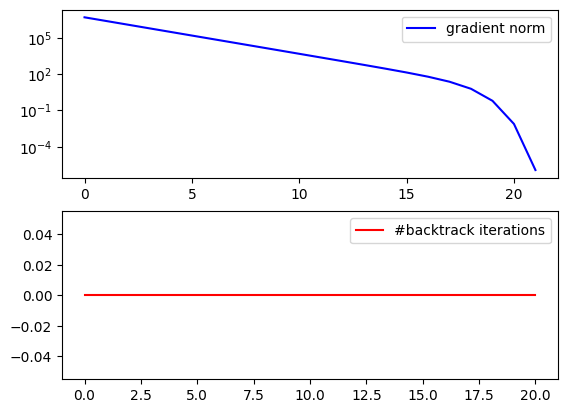

In [ ]:
# use Newton to solve the central path problem for some t
# prerequisites: newton, phik, psik, lpg1

t = 0.001               # regularization constant
epsilon = 1e-5          # select an accuracy at which the algorithm will stop
alpha = 0.3             # backtracking parameter
beta = 0.7              # backtracking parameter


x, backtrack, ftlist, xlist = newton(np.array(x0), t, epsilon, alpha, beta, lpg1)

plt.subplot(2, 1, 1)
#plt.plot(ftlist, 'b', label='$f_t(x_k)$')
plt.plot([np.linalg.norm(lpg1.nablat(x_iter,t)) for x_iter in xlist], 'b', label='gradient norm')
plt.yscale("log")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(backtrack, 'r', label='#backtrack iterations');
plt.legend();

def report_solutions(xlist: np.ndarray, t: float, pbm: LPGradients):
  i = 0
  for x_iter in xlist:
      print(f"""At iteration {i}:
      is it feasible? {np.all(lp1.A @ x_iter-lp1.b <= np.zeros(lp1.m))}
      the ft value {lpg1.ft(x_iter,t)}
      the c^Tx value {lpg1.f(x_iter)}
      the Barrier gives {lpg1.ft(x_iter,t)-lpg1.f(x_iter)}
      the norm of the gradient {np.linalg.norm(lpg1.nablat(x_iter,t))}
      the newton decrement was Dk = {-lpg1.nablat(x_iter,t) @ (np.linalg.solve(lpg1.hessiant(x_iter,t), -lpg1.nablat(x_iter,t))).T }
      """)
      i+=1


#     the solution is {x_iter}
#     the descent direction is d = {np.linalg.solve(lpg1.hessiant(x_iter,t), -lpg1.nablat(x_iter,t))}
report_solutions(xlist, t, lpg1)

In [ ]:
print(f"The value of the LP objective at the centering solution is {lpg1.f(x)} while the LP optimal value is {prob.value}")

The value of the LP objective at the centering solution is 32272.43861841129 while the LP optimal value is -5866.150143864937


The interior point method
======


The [interior point method](https://en.wikipedia.org/wiki/Interior-point_method) proceeds by solving a sequence of barrier problems $(\mathcal{B})$ with increasing regularization parameter $t_k=\mu\cdot  t_0$ for some $\mu > 1$ making the influence of the logarithmic barrier smaller and smaller at each iterate. While the problem for $t_0$--we saw above--is called the centering step, the solutions $x^*(t_{k})$ in the next iterations are called the "central path", and they approach the optimal LP solution as $t_{k}\to \infty$. Recall that the optimal LP solution sits at the boundary of the feasible set.

A crucial point in this method is to use a "warm restart" strategy: in order to solve for $x(t_{k})$, one should initialize the Newton steps using $x^*(t_{k-1})$. This is what makes interior point methods efficient.  Thanks to the use of a logarithmic barrier, one can show the upper bound $f(x(t_k))-f(x^*) \leq m/t_k$ ($m$ being the number of constraints), so that in order to a final error of $\epsilon$, one needs to use $k=0, \ldots, L$ such that
$$
	\frac{m}{t_{L}} = \frac{m}{t_0 \mu^{L}} \leq \epsilon.
$$
This shows that only $O(|\log(\epsilon)|)$ steps are necessary to reach $\epsilon$ precision.

Implement the method, and store the values of $f(x)=c^Tx$ during all the Newton steps for $t=t_k$.

In [ ]:
mu = lp1.m        # choose how fast we increase t (t_l+1 = t_l * mu) recommended mu = m
x = np.array(x0)  # initial feasible solution for the centering problem
t = 0.1           # choose initial regularization parameter (should be small)
epsilon = 1e-5    # choose a required precision
alpha = 0.3       # backtracking parameter in (0,0.5)
beta = 0.7        # backtracking parameter in (0,1)

Flist1 = np.array([])
while lp1.m / t > epsilon:
    x, backtrack, ftlist, xlist = newton(x, t, epsilon, alpha, beta, lpg1) # perform Newton iterate with initial solution x (the previous x^*(t))
    for x_iter in xlist:
      Flist1 = np.append(Flist1, lpg1.f(x_iter))
    t *= mu

Display the evolution of $f(x_{k,\ell})-f(x^\star)$ in logarithmic scale. This highlights the different steps of the algorithm (and migh even be non-decreasing), where the energy starts decaying and then stagnates, until $t=t_k$ is changed to $t=t_{k+1}$

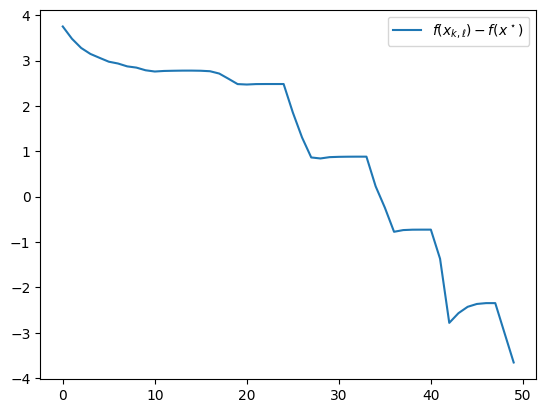

In [ ]:
plt.plot(np.log10(Flist1[0:-1] - np.min(Flist1)), label='$f(x_{k,\ell})-f(x^\star)$' )
plt.legend();

To bound the running time of the IP method, the important question to bound the complexity of the method is thus to bound the number of Newton steps (N). This requires additional hypotheses on $f$. If the function $f$ has a so-called self-concordance property, namely that for any $(x,y)$, $\phi(s) \eqdef f(s x + (1-s)y)$ satisfies
$$
	|\phi'''(s)| \leq 2 \phi''(s)^{3/2},
$$
one can then that only a constant number of Newton steps are required per iterations (note that $-\log$ being self-concordant, and quadratic function are self concordant, $f_t$ is itself self-concordant) when using the warm-restart initialization to computes the succession of $x(t_\ell)$.
This result might look surprising, but is possible because of the combination of the warm restart strategy with the self-concordance property of $f_t$: although problems become more and more difficult ($f_t$ is becoming less regular) as $t$ increases, the number of iterations of Newton stays constant.
This fundamental result supports the claim that interior point methods solve linear programs (and more general types of problems including SDP problems) in polynomial time (where polynomial refers to polynomial in $\log(\epsilon)$).

Display the influence of $\mu$. One can see that unless one used very small or very large $\mu$, all the runs are in the same ballpark, and one observe approximately a linear rate of convergence, with a constant number of inner Newton steps (index $k$) per interior point step (index $\ell$).

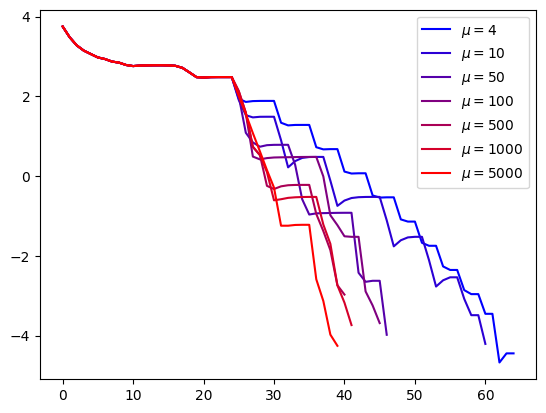

In [ ]:

epsilon = 1e-5            # choose a required precision
alpha = 0.3               # backtracking parameter in (0,0.5)
beta = 0.7                # backtracking parameter in (0,1)


mulist = np.array([4, 10, 50, 100, 500, 1000, 5000])
for it in range(0,len(mulist)):
    mu = mulist[it]
    # initialize
    x = np.array(x0)          # feasible solution
    Flist = np.array([])      # plot vector
    t = 0.1                   # starting regularization
    k = 0                     # central path iterations

    while lp1.m / t >= epsilon:
        x, backtrack, ftlist, xlist = newton(x, t, epsilon, alpha, beta, lpg1) # perform Newton iterate with initial solution x (the previous x^*(t))
        for x_iter in xlist:
          Flist = np.append(Flist, lpg1.f(x_iter))
        t *= mu
        k += 1

        if k > 100:
          print("Not converging stopping now...")
          break

    s = it / (len(mulist)-1)
    plt.plot( np.log10(Flist[0:-1]-prob.value), color=(s,0,1-s), label='$\mu=' + str(mu) +'$' )
plt.legend();

<script>
  $(document).ready(function(){
      $('div.prompt').hide();
  });
</script>

In [ ]:
print(lpg1.f(lp1.x_init))

AttributeError: 'LPInstance' object has no attribute 'x_init'

In [ ]:
fix the issue with x_init being modified by the above code